# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary

!pip install -U numpy
!pip install imbalanced-learn
!pip install --upgrade setuptools
!pip install --upgrade pip
!pip install xgboost
#import sys
#!{sys.executable} -m pip install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import imblearn

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import entropy
from sklearn.metrics import silhouette_score

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
import workspace_utils
from workspace_utils import active_session
 
with active_session():
    azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
    customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
    # do long-running work here

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
def seg_entropy(df,col,dropna=True):
    '''
    INPUT - df - pandas dataframe 
            col - string - the name of the column to find entryopy
    OUTPUT - 
            entropy - float value
    '''
    ent=entropy(df[col].value_counts(dropna=dropna))
    return ent

def unimportant_cols(df,threshold=90):
    '''
    Not In Use
    
    INPUT - df - pandas dataframe 
            threshold - null values more than this threshold
    OUTPUT - 
            columns list - list of columns with more than threshold null values
    '''
    return df.columns[df.isnull().sum()/df.shape[0] *100.0 > threshold ].tolist()

def convert_cols(df,cols=['CAMEO_DEUG_2015','CAMEO_INTL_2015']):
    '''
    Inplace ,cleans ,transforms,converts data type Classification Attributes 
    
    INPUT - df - pandas dataframe 
            cols - TBD transform coluns
    '''
    df_cols=df.columns.tolist()
    if 'CAMEO_DEUG_2015' in df_cols:
        df.CAMEO_DEUG_2015=df.CAMEO_DEUG_2015.replace('X',-1).astype(float)
    if 'CAMEO_INTL_2015' in df_cols:
        df.CAMEO_INTL_2015=df.CAMEO_INTL_2015.replace('XX',-1).astype(float)
    if 'CAMEO_DEU_2015' in df_cols:
        df.CAMEO_DEU_2015=df.CAMEO_DEU_2015.replace(np.nan,-1).replace('XX',-1).astype('str').apply(lambda x: x if x=='-1' else x[0]+ str(ord(x[1])-65)).astype(float)
    
def replace_nan(df,cols):
    '''
    INPUT - df - pandas dataframe 
            cols - cols replaced with median
    '''
    df_cols=df.columns.tolist()
    for col in cols:
        if col in df_cols:
            med=df[col].median()
            df[col]=df[col].replace(np.nan,med)
def replace_nan_with_val(df,cols,vals):
    '''
    INPUT - df - pandas dataframe 
            cols - cols whose nan is to be replaced 
            vals - value list
    '''
    df_cols=df.columns.tolist()
    for col,val in zip(cols,vals):
        if col in df_cols:
            df[col]=df[col].replace(np.nan,val)
def replace_nan_with_tuple(df,cols):
    '''
    INPUT - df - pandas dataframe 
            (col,val) - tuple col whose nan is to be replaced with val
    '''
    df_cols=df.columns.tolist()
    for col,val in cols:
        if col in df_cols:
            df[col]=df[col].replace(np.nan,val)
def replace_global_nan(df,val):
    '''
    INPUT - df - pandas dataframe 
            val - any col whose nan is to be replaced with val
    '''
    return df.replace(np.nan,val)

def get_dumm(df,cols):
    '''
    INPUT - df - pandas dataframe 
            cols - cols for one hot encoding
    '''
    if cols is None:
        cols=df.columns.tolist()
    return pd.get_dummies(df,columns=cols,prefix=cols,prefix_sep='-',dummy_na=True)

def seg_pca(df,dim=100):
    '''
    INPUT - df - pandas dataframe 
            dim - num of PCA components
    OUTPUT - 
            pca -PCA fitted object
            X - PCA transformed data
    '''
    pca=PCA(n_components=dim)
    X=pca.fit_transform(df)
    print("explained Variance")
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.sum())
    return pca,X

def kmeans(df,n_clusters=5,random_state=10,batch_size=1000):
    '''
    INPUT - df - pandas dataframe 
            n_clusters - num of KMean clusters
            random_state
            batch_size
    OUTPUT - 
            kmeans- fitted KMeans model
            
    '''
    #kmeans=MiniBatchKMeans(initn_clusters,random_state,batch_size)
    kmeans=KMeans(init='k-means++',n_clusters=n_clusters,random_state=random_state)
    kmeans.fit(df)
    return kmeans

def not_null_cols(df):
    '''
    INPUT - df - pandas dataframe 
    OUTPUT - List of non-null columns
    '''
    return df.columns[~df.isnull().any()].tolist()
    

In [4]:
#del_cols=unimportant_cols(azdias,90)
del_cols=[]
time_col='EINGEFUEGT_AM'
del_cols.append(time_col)
id_col='LNR'
del_cols.append(id_col)
Unimp_cols=['GEBURTSJAHR','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','D19_LETZTER_KAUF_BRANCHE']
del_cols.extend(Unimp_cols)
#del_cols.extend(chosen_cols)
del_cols=list(set(del_cols))
print(del_cols)
azdias=azdias.drop(del_cols,axis=1)
customers=customers.drop(del_cols,axis=1)



['MIN_GEBAEUDEJAHR', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'LNR', 'EINGEFUEGT_AM']


In [5]:
ent_vals=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(azdias,col)
    if ent is not None:
        ent_vals.append(ent)
    
#print(ent_vals)

cust_ent_vals=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(customers,col)
    if ent is not None:
        cust_ent_vals.append(ent)
    
## Choose columns whose entropy changes significantly between population and customers
chosen_dict={}
chosen_cols=[]
for i,col in enumerate((azdias.columns.tolist())):
    diff=(ent_vals[i] -cust_ent_vals[i]) /ent_vals[i] * 100
    diff=np.abs(diff)
    print(col,diff,'%',ent_vals[i],cust_ent_vals[i])
    if diff>10:
        chosen_cols.append(col)
        chosen_dict[col]=diff
sorted(chosen_dict.items(),key = lambda kv:kv[1],reverse=True)

AGER_TYP 53.13463189451998 % 0.8178341582776804 1.2523873277861717
AKT_DAT_KL 42.89168125535079 % 1.4043615815241857 0.8020072883042286
ALTER_HH 9.587643818955033 % 2.4907864912820834 2.729594228356857
ALTER_KIND1 1.2995673992239676 % 2.697419268211994 2.662364486781925
ALTER_KIND2 1.0661517938177274 % 2.4885538542412036 2.462022092684091
ALTER_KIND3 0.787794478657518 % 2.291348538803937 2.27329742152844
ALTER_KIND4 5.159927389661283 % 2.1459844224192075 2.0352531844289343
ALTERSKATEGORIE_FEIN 8.744051671361468 % 2.7672652245479816 2.525294123429889
ANZ_HAUSHALTE_AKTIV 29.26926412315785 % 2.9093607654596774 2.0578122787217574
ANZ_HH_TITEL 35.289912376113186 % 0.15501762244320297 0.20972320557094326
ANZ_KINDER 10.926096251186273 % 0.43151460631460586 0.3843669050907445
ANZ_PERSONEN 23.417149132554336 % 1.3557240796777612 1.6731960092418523
ANZ_STATISTISCHE_HAUSHALTE 30.080965438629764 % 2.7757071620592852 1.9407476499626606
ANZ_TITEL 274.2291429437465 % 0.026459415372509093 0.0990188433

[('TITEL_KZ', 362.6210360429252),
 ('ANZ_TITEL', 274.2291429437465),
 ('D19_BIO_OEKO', 82.55469802440915),
 ('D19_WEIN_FEINKOST', 80.28759422503283),
 ('D19_NAHRUNGSERGAENZUNG', 78.82205104450608),
 ('D19_BILDUNG', 78.74715295997396),
 ('D19_SAMMELARTIKEL', 76.38858302106354),
 ('D19_BEKLEIDUNG_GEH', 75.18365804046519),
 ('D19_LEBENSMITTEL', 57.855964758171),
 ('VHA', 56.99270864704372),
 ('D19_BANKEN_OFFLINE_DATUM', 54.86337535609308),
 ('AGER_TYP', 53.13463189451998),
 ('WOHNDAUER_2008', 52.41848058626037),
 ('D19_RATGEBER', 45.96339283788498),
 ('OST_WEST_KZ', 45.908857992995664),
 ('D19_HANDWERK', 45.219670031298534),
 ('D19_VERSAND_OFFLINE_DATUM', 44.744860587915234),
 ('D19_REISEN', 44.612690216633105),
 ('AKT_DAT_KL', 42.89168125535079),
 ('CJT_TYP_6', 42.81658319752861),
 ('CJT_TYP_5', 42.30506078582351),
 ('CJT_TYP_3', 41.32289341369471),
 ('D19_KOSMETIK', 38.70715822769628),
 ('KBA05_ANTG4', 37.85947350499947),
 ('RT_SCHNAEPPCHEN', 37.58029748872583),
 ('HH_DELTA_FLAG', 36.70

In [6]:
ent_vals2=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(azdias,col,dropna=False)
    if ent is not None:
        ent_vals2.append(ent)
    
#print(ent_vals)

cust_ent_vals2=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(customers,col,dropna=False)
    if ent is not None:
        cust_ent_vals2.append(ent)
    
## Choose columns whose entropy changes significantly between population and customers including null values
chosen_dict2={}
chosen_cols2=[]
for i,col in enumerate((azdias.columns.tolist())):
    
    diff=(ent_vals2[i] -cust_ent_vals2[i]) /ent_vals2[i] * 100
    diff=np.abs(diff)
    print(col,diff,'%',ent_vals2[i],cust_ent_vals2[i])
    if diff>10:
        chosen_cols2.append(col)
        chosen_dict2[col]=diff
sorted(chosen_dict2.items(),key = lambda kv:kv[1],reverse=True)

AGER_TYP 53.13463189451998 % 0.8178341582776804 1.2523873277861717
AKT_DAT_KL 26.16334165694144 % 1.5733047926753014 1.1616756844626281
ALTER_HH 1.9640897793039573 % 2.5701322350908726 2.620611939634889
ALTER_KIND1 28.330532422603817 % 0.5500687007058153 0.3942313091057587
ALTER_KIND2 17.32545276798548 % 0.22772659864562753 0.18827193435713946
ALTER_KIND3 3.6507640103346333 % 0.05719004240671975 0.05510216892104011
ALTER_KIND4 9.085900098749468 % 0.013184678365956494 0.011986731661284254
ALTERSKATEGORIE_FEIN 5.140168212984858 % 2.5574117756827754 2.425956508513998
ANZ_HAUSHALTE_AKTIV 28.73485665814139 % 2.9401788571551544 2.095322677058641
ANZ_HH_TITEL 53.00067001180299 % 0.48224509169643476 0.7378382213945789
ANZ_KINDER 24.22355134934488 % 0.6806885120195177 0.8455754432576572
ANZ_PERSONEN 19.126027773364225 % 1.528678425831542 1.8210538861215098
ANZ_STATISTISCHE_HAUSHALTE 28.78006001828075 % 2.8204943656243655 2.0087543943854462
ANZ_TITEL 103.72998662542163 % 0.3090382245514787 0.629

[('TITEL_KZ', 105.80243210537866),
 ('ANZ_TITEL', 103.72998662542163),
 ('D19_BIO_OEKO', 82.55469802440915),
 ('SOHO_KZ', 81.12336111759127),
 ('D19_WEIN_FEINKOST', 80.28759422503283),
 ('D19_NAHRUNGSERGAENZUNG', 78.82205104450608),
 ('D19_BILDUNG', 78.74715295997396),
 ('D19_SAMMELARTIKEL', 76.38858302106354),
 ('D19_BEKLEIDUNG_GEH', 75.18365804046519),
 ('EXTSEL992', 67.74472449532884),
 ('D19_LEBENSMITTEL', 57.855964758171),
 ('D19_BANKEN_OFFLINE_DATUM', 54.86337535609308),
 ('AGER_TYP', 53.13463189451998),
 ('ANZ_HH_TITEL', 53.00067001180299),
 ('VHA', 49.17450757516125),
 ('D19_RATGEBER', 45.96339283788498),
 ('D19_HANDWERK', 45.219670031298534),
 ('D19_VERSAND_OFFLINE_DATUM', 44.744860587915234),
 ('D19_REISEN', 44.612690216633105),
 ('DSL_FLAG', 41.47163862691111),
 ('HH_DELTA_FLAG', 40.19397114068873),
 ('CJT_TYP_6', 39.25135348257203),
 ('CJT_TYP_5', 38.79913971144589),
 ('D19_KOSMETIK', 38.70715822769628),
 ('CJT_TYP_3', 37.8676589127492),
 ('UNGLEICHENN_FLAG', 37.65762389315

In [7]:
print(set(chosen_cols).symmetric_difference(chosen_cols2))
common_cols=np.intersect1d(chosen_cols,chosen_cols2)
union_cols=np.union1d(chosen_cols,chosen_cols2)
print(union_cols)

{'VK_DISTANZ', 'KBA13_ANZAHL_PKW', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'KBA13_KMH_110', 'KK_KUNDENTYP', 'KBA05_MAXAH', 'KBA13_ANTG4', 'PLZ8_ANTG4', 'CAMEO_DEUG_2015', 'KBA13_KRSSEG_KLEIN', 'D19_VERSAND_ONLINE_QUOTE_12', 'OST_WEST_KZ', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'MOBI_RASTER', 'ALTER_KIND2', 'ALTER_KIND1', 'ONLINE_AFFINITAET', 'KBA05_AUTOQUOT', 'EXTSEL992', 'KBA05_ANTG4'}
['AGER_TYP' 'AKT_DAT_KL' 'ALTER_KIND1' 'ALTER_KIND2' 'ANZ_HAUSHALTE_AKTIV'
 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN' 'ANZ_STATISTISCHE_HAUSHALTE'
 'ANZ_TITEL' 'CAMEO_DEUG_2015' 'CJT_KATALOGNUTZER' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BEKLEIDUNG_GEH' 'D19_BEKLEIDUNG_REST'
 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD' 'D19_DIGIT_SERV' 'D19_ENERGI

In [8]:
len(union_cols)

117

In [9]:
def transform_train(df,union_cols):
    '''
    Cleans,Transforms Dataframe for final unsupervised,supervised analysis
    
    INPUT - df - pandas dataframe 
            union_cols - columns to be included
    OUTPUT - 
            df- pandas dataframe 
    '''
    convert_cols(df)
    df=df[union_cols]
    numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE']
    replace_nan(df,numeric_cols)
    
    country_cols=['OST_WEST_KZ']
    df=get_dumm(df,country_cols)
    
    cols_entropy_10=[('KBA05_AUTOQUOT',9),
    ('KBA05_BAUMAX',0),
    ('KBA05_MAXAH',9),
    ('KBA05_SEG6',9),
    ('RETOURTYP_BK_S',0),
    ('ONLINE_AFFINITAET',0),
    ('D19_LOTTO',0),
    ('W_KEIT_KIND_HH',0),
    ('KBA13_BAUMAX',0)]
    replace_nan_with_tuple(df,cols_entropy_10)
    
    
    
    median_cols=['MOBI_RASTER','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','EXTSEL992']
    replace_nan(df,median_cols)
    
    
    cols_9=[('KBA05_ALTER1',9),
    ('KBA05_ALTER2',9),
    ('KBA05_ALTER4',9),
    ('KBA05_CCM1',9),
    ('KBA05_CCM2',9),
    ('KBA05_CCM3',9),
    ('KBA05_DIESEL',9),
    ('KBA05_FRAU',9),
    ('KBA05_HERST2',9),
    ('KBA05_HERST4',9),
    ('KBA05_HERST5',9),
    ('KBA05_KRSAQUOT',9),
    ('KBA05_KRSKLEIN',9),
    ('KBA05_KRSOBER',9),
    ('KBA05_KRSVAN',9),
    ('KBA05_KRSZUL',9),
    ('KBA05_KW1',9),
    ('KBA05_KW2',9),
    ('KBA05_MAXHERST',9),
    ('KBA05_MAXVORB',9),
    ('KBA05_MOD2',9),
    ('KBA05_MOD3',9),
    ('KBA05_MOD4',9),
    ('KBA05_SEG1',9),
    ('KBA05_SEG10',9),
    ('KBA05_SEG2',9),
    ('KBA05_SEG3',9),
    ('KBA05_SEG4',9),
    ('KBA05_SEG8',9),
    ('KBA05_VORB0',9),
    ('KBA05_VORB1',9),
    ('KBA05_VORB2',9),
    ('KBA05_ZUL1',9),
    ('KBA05_ZUL2',9),
    ('KBA05_ZUL3',9),
    ('KBA05_ZUL4',9),
    ('KBA05_HERST1',9),
    ('KBA05_HERST3',9),
    ('KBA05_KRSHERST2',9)]
    replace_nan_with_tuple(df,cols_9)
    
    
    median_cols=['ALTERSKATEGORIE_FEIN']
    replace_nan(df,median_cols)
    
    
    cols_0=[('ALTER_HH',0)]
    replace_nan_with_tuple(df,cols_0)
    
    
    df=replace_global_nan(df,-1)
    return df

In [10]:
azdias=transform_train(azdias,union_cols)
customers=transform_train(customers,union_cols)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
def remove_corr_cols(corr,compare=0.9):
    '''
    INPUT - corr - correlation matrix 
            compare - threshold for similarity
    OUTPUT - 
            list- columns with removed correlated columns
    '''
    similar_cols=corr.columns[(corr>compare).sum(axis=1) > 1]
    remove_cols=[]
    for col in similar_cols:
        if col not in remove_cols:
            print("\n",col, "--similar to--" , corr.columns[(corr.loc[col] > compare) & ~(corr.loc[col] == 1)].tolist())
            remove_cols.extend(corr.columns[(corr.loc[col] > compare) & ~(corr.loc[col] == 1)].tolist())
    print(set(remove_cols))

    uc=union_cols.tolist()
    #uc=union_cols.copy()
    #print(uc)
    for col in set(remove_cols):
        print("--",col)
        if col in uc:
            uc.remove(col)
    print(uc,len(uc))
    return uc

In [12]:
corr=azdias.corr()
uc=remove_corr_cols(corr)


 ANZ_HAUSHALTE_AKTIV --similar to-- ['ANZ_STATISTISCHE_HAUSHALTE']

 D19_GESAMT_ANZ_12 --similar to-- ['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12']

 D19_GESAMT_ONLINE_QUOTE_12 --similar to-- ['D19_VERSAND_ONLINE_QUOTE_12']

 D19_VERSAND_ANZ_24 --similar to-- ['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12']

 KBA05_AUTOQUOT --similar to-- ['KBA05_SEG6']

 KBA13_ANTG4 --similar to-- ['PLZ8_ANTG4']

 KBA13_BAUMAX --similar to-- ['PLZ8_BAUMAX']

 LP_LEBENSPHASE_FEIN --similar to-- ['LP_LEBENSPHASE_GROB']

 SOHO_KZ --similar to-- ['TITEL_KZ']

 VK_DISTANZ --similar to-- ['VK_ZG11']
{'ANZ_STATISTISCHE_HAUSHALTE', 'LP_LEBENSPHASE_GROB', 'D19_VERSAND_ANZ_12', 'KBA05_SEG6', 'PLZ8_ANTG4', 'TITEL_KZ', 'D19_GESAMT_ANZ_24', 'VK_ZG11', 'D19_VERSAND_ONLINE_QUOTE_12', 'PLZ8_BAUMAX'}
-- ANZ_STATISTISCHE_HAUSHALTE
-- LP_LEBENSPHASE_GROB
-- D19_VERSAND_ANZ_12
-- KBA05_SEG6
-- PLZ8_ANTG4
-- TITEL_KZ
-- D19_GESAMT_ANZ_24
-- VK_ZG11
-- D19_VERSAND_ONLINE_QUOTE_12
-- PLZ8_BAUMAX
['AGER_TYP', 'AKT_DAT_KL', 'ALTER_

 ANZ_HAUSHALTE_AKTIV --similar to-- ['ANZ_STATISTISCHE_HAUSHALTE']

 D19_GESAMT_ANZ_12 --similar to-- ['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12']

 D19_GESAMT_ONLINE_QUOTE_12 --similar to-- ['D19_VERSAND_ONLINE_QUOTE_12']

 D19_VERSAND_ANZ_24 --similar to-- ['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12']

 KBA05_AUTOQUOT --similar to-- ['KBA05_SEG6']

 KBA13_ANTG4 --similar to-- ['PLZ8_ANTG4']

 KBA13_BAUMAX --similar to-- ['PLZ8_BAUMAX']

 LP_LEBENSPHASE_FEIN --similar to-- ['LP_LEBENSPHASE_GROB']

 SOHO_KZ --similar to-- ['TITEL_KZ']

 VK_DISTANZ --similar to-- ['VK_ZG11']
{'ANZ_STATISTISCHE_HAUSHALTE', 'TITEL_KZ', 'PLZ8_BAUMAX', 'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_24', 'PLZ8_ANTG4', 'VK_ZG11', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_SEG6', 'LP_LEBENSPHASE_GROB'}
-- ANZ_STATISTISCHE_HAUSHALTE
-- TITEL_KZ
-- PLZ8_BAUMAX
-- D19_VERSAND_ANZ_12
-- D19_GESAMT_ANZ_24
-- PLZ8_ANTG4
-- VK_ZG11
-- D19_VERSAND_ONLINE_QUOTE_12
-- KBA05_SEG6
-- LP_LEBENSPHASE_GROB
['AGER_TYP', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_TITEL', 'CAMEO_DEUG_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_FLAG', 'EXTSEL992', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_MAXAH', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW', 'KBA13_BAUMAX', 'KBA13_KMH_110', 'KBA13_KMH_251', 'KBA13_KRSSEG_KLEIN', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'LP_LEBENSPHASE_FEIN', 'MOBI_RASTER', 'NATIONALITAET_KZ', 'ONLINE_AFFINITAET', 'OST_WEST_KZ', 'RETOURTYP_BK_S', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KRIT', 'SEMIO_LUST', 'SEMIO_PFLICHT', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SOHO_KZ', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'VHA', 'VK_DISTANZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'ZABEOTYP'] 107

In [13]:
print(customers.shape,azdias.shape)
na_cols1=azdias.columns[azdias.isnull().any()].tolist()
na_cols2=customers.columns[customers.isnull().any()].tolist()
na_cols3=np.union1d(na_cols1,na_cols2)
na_cols3,len(na_cols3)
#azdias.AKT_DAT_KL.median()
print(na_cols3)

(191652, 119) (891221, 119)
[]


In [14]:
transformed_cols=azdias.columns.tolist()

In [15]:
## Perform Scaling before PCA
std_scaler=StandardScaler()
with active_session():
    azdias=std_scaler.fit_transform(azdias)

In [16]:
## Peform PCA
with active_session():
    pop_pca,pop_pca_df=seg_pca(azdias,dim=100)


explained Variance
[0.15911067 0.11795306 0.07829145 0.03608249 0.02923297 0.02790533
 0.02158216 0.01862138 0.01619815 0.0152396  0.01505069 0.01347042
 0.01227783 0.01182264 0.01146067 0.01089034 0.00997846 0.00973352
 0.00953352 0.00932409 0.00898696 0.00870383 0.00837283 0.00812667
 0.00804875 0.00796757 0.00778796 0.00764259 0.00758204 0.00746207
 0.00737653 0.00727215 0.00699154 0.0068399  0.00675805 0.00668508
 0.00664108 0.00651817 0.00636708 0.00632792 0.00617672 0.00613271
 0.00603203 0.00581276 0.00570688 0.00564388 0.00559713 0.00558207
 0.00551533 0.00545779 0.00535993 0.00529325 0.00524567 0.00513029
 0.00500053 0.0048951  0.0047841  0.00474064 0.00466962 0.0045785
 0.00440101 0.00425737 0.00417135 0.00408005 0.00394646 0.00387151
 0.00375662 0.00358636 0.00348712 0.00345678 0.00336862 0.00320574
 0.0030794  0.00301229 0.0029262  0.00279475 0.00263159 0.00247038
 0.00242116 0.00236319 0.00229746 0.00229426 0.00221541 0.00211467
 0.00209309 0.00200676 0.00197235 0.00186102

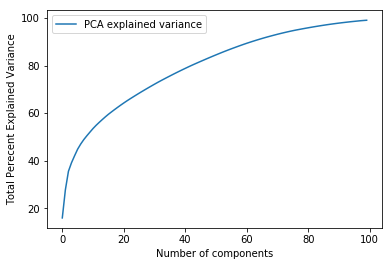

In [29]:
## Plot PCA 

sum=0
xax=[]
yax=[]
for i,val in enumerate(pop_pca.explained_variance_ratio_):
    sum+=val
    xax.append(i)
    yax.append(sum *100)
plt.plot(xax,yax,label='PCA explained variance');
plt.xlabel('Number of components')
plt.ylabel('Total Perecent Explained Variance')
plt.legend()
plt.show()

In [30]:
## Transform customers dataframe using scaler and PCA for customer clustering analysis
cust_pca_df=pop_pca.transform(std_scaler.transform(customers))

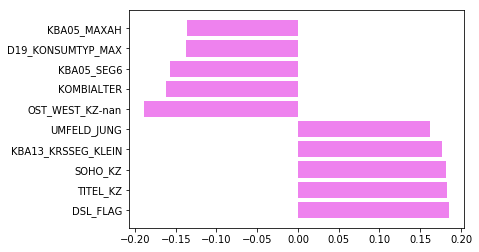

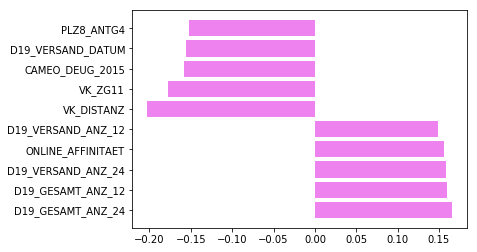

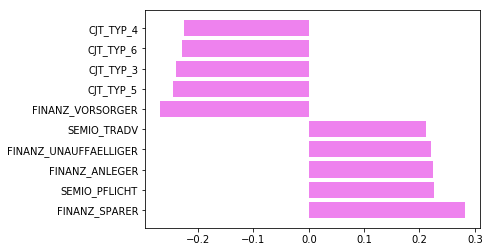

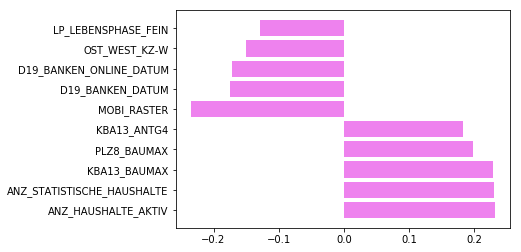

In [31]:
## Plot features of PCA components
comps_df=pd.DataFrame(pop_pca.components_,columns=transformed_cols)

for k in range(4):
    i=[]
    j=[]
    v=comps_df.iloc[k].sort_values(ascending=False)[:5]
    i=v.index.tolist()
    j=v.values.astype('float').tolist()
    
    v=comps_df.iloc[k].sort_values(ascending=True)[:5]
    i.extend(v.index.tolist())
    j.extend(v.values.astype('float').tolist())

    plt.barh(range(len(i)),j,tick_label=i,color='violet');
    plt.show()


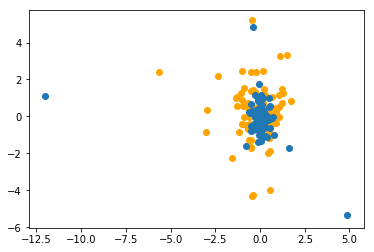

In [32]:
#from sklearn.manifold import TSNE
#plt.scatter(TNSE.fit_transform(customers2))
plt.scatter(cust_pca_df[0],cust_pca_df[1],color='orange')
plt.scatter(pop_pca_df[0],pop_pca_df[1])

In [33]:
from sklearn.manifold import TSNE
#plt.scatter(TSNE().fit_transform(customers2))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [23]:
## Choosing number of clusters using elbow curve
x= range(2,20)
y=[]
sil_y=[]
with active_session():
    for k in range(2,20):
        pop_kmeans=kmeans(pop_pca_df,n_clusters=k)
        #print(pop_kmeans.inertia_)
        y.append(pop_kmeans.inertia_)
        #sil_y.append(silhouette_score(pop_pca_df,pop_kmeans.labels_,sample_size=10000))

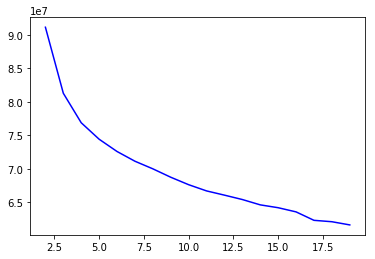

In [24]:
plt.plot(x,y,color='blue')
plt.show()

In [17]:
# Final Kmeans with 12 clusters
pop_kmeans=kmeans(pop_pca_df,n_clusters=12)

In [34]:
len(pop_kmeans.cluster_centers_),
labels=pop_kmeans.labels_
total=labels.shape[0]
pop_p=[(labels==0).sum()/total *100,
(labels==1).sum()/total *100,
(labels==2).sum()/total *100,
(labels==3).sum()/total *100,
(labels==4).sum()/total *100,
(labels==5).sum()/total *100,
(labels==6).sum()/total *100,
(labels==7).sum()/total *100,
(labels==8).sum()/total *100,
(labels==8).sum()/total *100,
(labels==10).sum()/total *100,
(labels==11).sum()/total *100,       
      ]


In [35]:
cust_pred_labels=pop_kmeans.predict(cust_pca_df)

labels=cust_pred_labels
total=labels.shape[0]
cust_p=[(labels==0).sum()/total *100,
(labels==1).sum()/total *100,
(labels==2).sum()/total *100,
(labels==3).sum()/total *100,
(labels==4).sum()/total *100,
(labels==5).sum()/total *100,
(labels==6).sum()/total *100,
(labels==7).sum()/total *100,
(labels==8).sum()/total *100,
(labels==8).sum()/total *100,
(labels==10).sum()/total *100,
(labels==11).sum()/total *100,            
]

In [36]:
#plt.bar(range(0,34,3),pop_p,label='population');
#plt.bar(range(1,35,3),cust_p,color='orange',label='customers');
#plt.xlabel('clusters')
#plt.ylabel('share of people')
#plt.xticks([]);

#plt.legend();



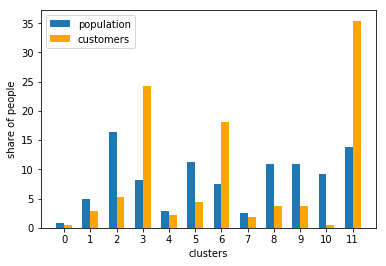

In [37]:
## Plot customers and population clusters
clusters=np.arange(0,12)
width=0.3
plt.bar(clusters-width/2,pop_p,width,label='population');
plt.bar(clusters+width/2,cust_p,width,color='orange',label='customers');
plt.xlabel('clusters')
plt.ylabel('share of people')
plt.xticks(clusters);
#pop_p,cust_p
plt.legend();

In [38]:
## Find the difference between clusters of maximum customers and minimum customers
cust_11=customers[(labels==11)].mean()
cust_10= customers[(labels==10)].mean()
sorted_cust=(cust_11-cust_10).sort_values(ascending=False)

max_diff_clusters=pd.DataFrame()
max_diff_clusters['Attribute']=sorted_cust.index.tolist()
max_diff_clusters['Cluster_10']=cust_10[sorted_cust.index.tolist()].values.tolist()
max_diff_clusters['Difference']=sorted_cust.values.tolist()
max_diff_clusters['Cluster_11']=cust_11[sorted_cust.index.tolist()].values.tolist()
max_diff_clusters2=max_diff_clusters.iloc[:6,:]
max_diff_clusters3=max_diff_clusters.iloc[-6:,:]
max_diff_clusters4=pd.concat([max_diff_clusters2,max_diff_clusters3],axis=0)
max_diff_clusters4.style.bar(subset=['Difference'],align='mid',color=['red','green'])

,Attribute,Cluster_10,Difference,Cluster_11
0,KBA13_ANZAHL_PKW,590.608,87.0321,677.641
1,LP_LEBENSPHASE_FEIN,11.8666,10.5232,22.3898
2,EXTSEL992,33.8887,3.41576,37.3044
3,LP_LEBENSPHASE_GROB,3.66987,2.85536,6.52523
4,FINANZ_VORSORGER,2.26775,2.56514,4.83289
5,SEMIO_LUST,3.31286,2.51286,5.82572
113,SEMIO_FAM,6.38964,-2.51767,3.87197
114,FINANZ_SPARER,3.69482,-2.54706,1.14776
115,VK_ZG11,5.38772,-2.63937,2.74835
116,VK_DISTANZ,7.50576,-3.08419,4.42157


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [39]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
#uc=['AGER_TYP', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_TITEL', 'CAMEO_DEUG_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_FLAG', 'EXTSEL992', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_MAXAH', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW', 'KBA13_BAUMAX', 'KBA13_KMH_110', 'KBA13_KMH_251', 'KBA13_KRSSEG_KLEIN', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'LP_LEBENSPHASE_FEIN', 'MOBI_RASTER', 'NATIONALITAET_KZ', 'ONLINE_AFFINITAET', 'OST_WEST_KZ', 'RETOURTYP_BK_S', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KRIT', 'SEMIO_LUST', 'SEMIO_PFLICHT', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SOHO_KZ', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'VHA', 'VK_DISTANZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'ZABEOTYP'] 

In [41]:
mailout_train_cluster = mailout_train.copy()
u_c=union_cols.tolist()
u_c.append('RESPONSE')
mailout_train_cluster=transform_train(mailout_train_cluster,u_c)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
u2=uc.copy()
#u2=union_cols.tolist()
#u2=ind_cols.copy()
u2.append('RESPONSE')
#u2.append('EINGEZOGENAM_HH_JAHR')
#u2.append('GEBURTSJAHR')

In [43]:
#rem_cols=['D19_LETZTER_KAUF_BRANCHE', 'EINGEZOGENAM_HH_JAHR', 'EINGEFUEGT_AM', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR']
#rem_cols=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'MIN_GEBAEUDEJAHR']
#u3=mailout_train.columns.tolist()
#for col in rem_cols:
#    u3.remove(col)


In [44]:
def plot_cluster(train_pos):
    '''
    plotting the cluster 
    INPUT - df - pandas dataframe 
    '''
    train_positive_df=pop_pca.transform(std_scaler.transform(train_pos))
    labels=pop_kmeans.predict(train_positive_df)
    total=labels.shape[0]
    train_pos_p=[(labels==0).sum()/total *100,
    (labels==1).sum()/total *100,
    (labels==2).sum()/total *100,
    (labels==3).sum()/total *100,
    (labels==4).sum()/total *100,
    (labels==5).sum()/total *100,
    (labels==6).sum()/total *100,
    (labels==7).sum()/total *100,
    (labels==8).sum()/total *100,
    (labels==8).sum()/total *100,
    (labels==10).sum()/total *100,
    (labels==11).sum()/total *100,
                  ]
    clusters=np.arange(0,12)
    width=0.35
    plt.bar(clusters,train_pos_p,width,color='purple',label='Leads');
    plt.xlabel('clusters')
    plt.ylabel('share of people')
    plt.legend();

532


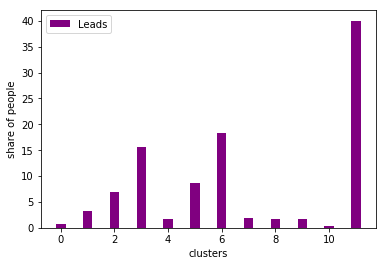

In [45]:
train_positive=mailout_train_cluster[mailout_train_cluster.RESPONSE==1]
print(train_positive.shape[0])
train_pos=train_positive.drop('RESPONSE',axis=1)
plot_cluster(train_pos)


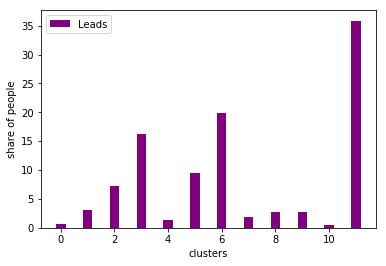

In [46]:
train_negative=mailout_train_cluster[mailout_train_cluster.RESPONSE==0]
train_neg=train_negative.drop('RESPONSE',axis=1)
plot_cluster(train_neg)


In [47]:
mailout_train=transform_train(mailout_train,u2)
#mailout_train=transform_train(mailout_train,u3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
print(np.__version__)
print(sklearn.__version__)
print(imblearn.__version__)

1.19.5
0.24.2
0.8.0


In [49]:
X=mailout_train.drop('RESPONSE',axis=1)
y=mailout_train.RESPONSE
print(X.shape)
#X=pop_pca.transform(std_scaler.transform(X))


(42962, 109)


In [130]:
#scaler=StandardScaler()
#scaler=RobustScaler()
#X=scaler.fit_transform(X)


In [50]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=24,stratify=y)

In [51]:
#x_train=scaler.fit_transform(x_train)
#x_test=scaler.transform(x_test)

In [52]:
smote=SMOTE()
x_smote,y_smote=smote.fit_resample(x_train,y_train)

In [53]:
x_smote.shape,y_smote.sum(),x_train.shape,x_test.shape,y_train.shape,y_test.shape

((63644, 109), 31822, (32221, 109), (10741, 109), (32221,), (10741,))

In [54]:
def train_model(model,x_train,y_train,x_test,y_test):
    '''
    Fits a model,finds ROC-AUC, PR-AUC metric
    INPUT - model - ML model
            x_train - training dataset
            y_train - labels of training data
            x_test - testing dataset 
            y_test - labels of testing dataset
    '''
    model.fit(x_train,y_train)
    #early_stopping_rounds=5,
    #model.fit(x_train,y_train,eval_set=[(x_test,y_test)])
    print(f'training accuracy {model.score(x_train,y_train)}')
    pred=model.predict(x_test)
    proba=model.predict_proba(x_test)
    print('testing metrics')
    print(classification_report(y_test,pred))
    print(f"ROC AUC Score {roc_auc_score(y_test,proba[:,1])} ")
    p,r,t=precision_recall_curve(y_test,proba[:,1])
    print(f"AUC: {auc(r,p)}")

In [136]:
print("cross val with SMOTE")
models=[]
#models.append(LogisticRegression(class_weight='balanced'))
models.append(AdaBoostClassifier())
models.append(GradientBoostingClassifier())
models.append(RandomForestClassifier(class_weight='balanced'))
with active_session():
    for model in models:
        cv_scores=cross_val_score(model,x_smote,y_smote,scoring='roc_auc',cv=5)
        print(cv_scores)
        print(cv_scores.mean(),cv_scores.std())
        print()

cross val with SMOTE
[0.96027709 0.98368307 0.98291884 0.98379488 0.98266403]
0.9786675821027284 0.009205427373463925

[0.9722619  0.99100629 0.99114803 0.9913326  0.99089478]
0.9873287194039151 0.00753483495762085

[0.98201291 0.99149695 0.99177655 0.99171354 0.99155033]
0.9897100551673113 0.0038499342834597957



In [137]:
print("cross val with out SMOTE")
models=[]
#models.append(LogisticRegression(class_weight='balanced'))
models.append(AdaBoostClassifier())
models.append(GradientBoostingClassifier())
models.append(RandomForestClassifier(class_weight='balanced'))
with active_session():
    for model in models:
        cv_scores=cross_val_score(model,x_train,y_train,scoring='roc_auc',cv=5)
        print(cv_scores)
        print(cv_scores.mean(),cv_scores.std())
        print()

cross val with out SMOTE
[0.71246269 0.7711635  0.73872368 0.72543015 0.71097777]
0.7317515578256766 0.022115528717840373

[0.77413688 0.77079062 0.76100035 0.7314749  0.72656348]
0.7527932464167953 0.0199463542436476

[0.63659564 0.68468086 0.62837641 0.62039696 0.54742693]
0.6234953612315 0.044125079252049296



In [151]:
print("With SMOTE")
models=[]
#models.append(LogisticRegression(max_iter=500,class_weight='balanced'))
#models.append(AdaBoostClassifier(n_estimators=100))
#models.append(RandomForestClassifier(class_weight='balanced',max_depth=5,n_estimators=25))
models.append(GradientBoostingClassifier(n_estimators=20,max_depth=5))
#models.append(XGBoostClassifier())
#models.append(XGBClassifier())
for model in models:
    train_model(model,x_smote,y_smote,x_test,y_test)

With SMOTE
training accuracy 0.9080196090754824
testing metrics
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10608
           1       0.05      0.18      0.07       133

    accuracy                           0.94     10741
   macro avg       0.52      0.57      0.52     10741
weighted avg       0.98      0.94      0.96     10741

ROC AUC Score 0.7173196707832931 
AUC: 0.02788996744485351


In [55]:
print("Without SMOTE")
models=[]
#models.append(LogisticRegression(max_iter=500,class_weight='balanced'))
#models.append(AdaBoostClassifier(n_estimators=25))
#models.append(RandomForestClassifier(class_weight='balanced'))
#best model so far
models.append(GradientBoostingClassifier(n_estimators=20,max_depth=5))
#,max_features='auto',learning_rate=0.05))
#models.append(GradientBoostingClassifier(n_estimators=100,max_depth=5,subsample=0.5,learning_rate=0.1))
#max_features='auto',learning_rate=0.1,min_samples_split=10)
#models.append(GradientBoostingClassifier(n_estimators=100,max_depth=6,max_features='auto',learning_rate=0.1))
#models.append(XGBClassifier(objective='binary:logistic',eval_metric='rmse',eta=0.1,n_estimators=75))
#DecisionTreeClassifier(max_depth=1)class_weight='balanced'
#models.append(KNeighborsClassifier(20))

for model in models:
    train_model(model,x_train,y_train,x_test,y_test)



Without SMOTE
training accuracy 0.9886099127897955
testing metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10608
           1       0.00      0.00      0.00       133

    accuracy                           0.99     10741
   macro avg       0.49      0.50      0.50     10741
weighted avg       0.98      0.99      0.98     10741

ROC AUC Score 0.7854049008267273 
AUC: 0.03765379472833684


In [81]:
from sklearn.model_selection import RandomizedSearchCV
print('RandomizedSearchCV')
models=[]
#models.append(LogisticRegression(max_iter=500,class_weight='balanced'))
#models.append(AdaBoostClassifier())
models.append(GradientBoostingClassifier())
#models.append(RandomForestClassifier(class_weight='balanced'))
params={
    'n_estimators':[10,15,20,25,50,55,60,65,70,75],
    'max_depth':[3,4,5,6],
    'learning_rate':[0.01,0.05,0.1,0.5,1]
}
#'max_depth':[3,4,5]
#'learning_rate':[0.01,0.05,0.5,1],
with active_session():
    for model in models:
        cv=RandomizedSearchCV(model,params,scoring='roc_auc',n_iter=10)
        cv.fit(x_train,y_train)
        print(cv.best_params_)

RandomizedSearchCV
{'n_estimators': 15, 'max_depth': 4, 'learning_rate': 0.1}


In [82]:
proba=cv.predict_proba(x_test)
print('testing metrics')
print(f"ROC AUC Score {roc_auc_score(y_test,proba[:,1])} ")

testing metrics
ROC AUC Score 0.7773477812177503 


In [83]:
print('GridSearchCV')
models=[]
#models.append(LogisticRegression(max_iter=500,class_weight='balanced'))
#models.append(AdaBoostClassifier())
models.append(GradientBoostingClassifier())
#models.append(RandomForestClassifier(class_weight='balanced'))
params={
    'n_estimators':[10,15,18,20,25,50,55,60,65,70,75],
    'max_depth':[4,5]
}
#'max_depth':[3,4,5]
#'learning_rate':[0.01,0.05,0.5,1],
with active_session():
    for model in models:
        cv=GridSearchCV(model,params,scoring='roc_auc')
        cv.fit(x_train,y_train)
        print(cv.best_params_)

GridSearchCV
{'max_depth': 4, 'n_estimators': 50}


In [84]:
proba=cv.predict_proba(x_test)
print('testing metrics')
print(f"ROC AUC Score {roc_auc_score(y_test,proba[:,1])} ")

testing metrics
ROC AUC Score 0.7750984503112986 


In [85]:
#OPTIONAL: Modelling on Full training Set after choosing the best model and hyper params

#models=[]

#models.append(GradientBoostingClassifier(n_estimators=15,max_depth=5))

#with active_session():
#    for model in models:
#        train_model(model,X,y,X,y)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [56]:
mailout_test1 = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
mailout_test1_cluster = mailout_test1.copy()
mailout_test1_cluster=transform_train(mailout_test1_cluster,union_cols.tolist())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


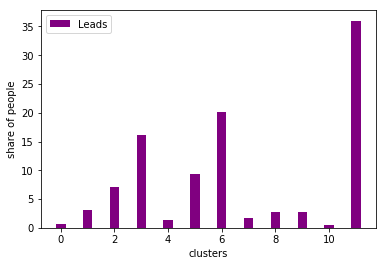

In [58]:
plot_cluster(mailout_test1_cluster)

In [59]:
results=pd.DataFrame()
results['LNR']=mailout_test1.LNR

In [60]:
u10=u2.copy()
u10.remove('RESPONSE')

In [61]:
mailout_test=transform_train(mailout_test1,u10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
#kaggle=pop_pca.transform(mailout_test)
kaggle=mailout_test
#kaggle=scaler.transform(kaggle)

In [63]:
#Manual Tuned Model 

for model in models:
    preds=model.predict(kaggle)
    pred=model.predict_proba(kaggle)
    results['RESPONSE']=pred[:,1]
    break;
(pred[:,1] >0.5 ).sum(),(pred[:,1] >0.7 ).sum(),(pred[:,1] >0.7 ).sum()
    

(41, 33, 33)

In [64]:
results.to_csv('aravind-manual-model.csv',index=None)

In [149]:
#Grid Search Model
preds=cv.predict(kaggle)
pred=cv.predict_proba(kaggle)
results['RESPONSE']=pred[:,1]

(pred[:,1] >0.5 ).sum(),(pred[:,1] >0.7 ).sum(),(pred[:,1] >0.7 ).sum()

(37, 30, 30)

In [150]:
results.to_csv('aravind-grid-search-cv.csv',index=None)